# Naive Bayes

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import time
import pickle
from collections import defaultdict 

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB

#Nos modules
from modules.naivebayes import OurNaiveBayesClassifier as nb
import modules.feature_selection as fs
import modules.scoring as sc

## 1. Importation des données

In [3]:
data = pd.read_csv("data.csv")
featureNames = [e for e in data.columns]

# On supprime la premiere colonne
data = data.drop(['filename'],axis=1)

#Test
#data = data.drop(columns=['chroma_stft','rms','spectral_centroid','spectral_bandwidth','rolloff','zero_crossing_rate','spectral_flatness','tonnetz','estimated_tempo','spectral_contrast'])
#data = data.drop(columns=['estimated_tempo'])

# On change les noms des genres par des entiers (de 0 a 9) car notre random forest ne prend en compte que des entiers comme labels

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
labels = encoder.fit_transform(genre_list)
data.iloc[:, -1] = labels

## 2. Apprentissage du modèle de base

On sépare tout d'abord le jeu de données pour constituer un ensemble d'apprentissage et de validation. <br>
Le Gaussian Naive Bayes ne prend pas d'hyper-paramètres.

In [4]:
# On separe le dataset en train set et test set (80%/20%)
data2 = data.copy()
train_set = data2.sample(frac=0.80, random_state=rd.randint(0,100000))
test_set = data2.drop(train_set.index)

In [5]:
classifier = nb.OurNaiveBayesClassifier()
classifier = classifier.fit(train_set)

new_test_set = test_set.copy()
new_test_set = new_test_set.drop(columns=['genre/label'])

predictions = classifier.predict(new_test_set)
result = classifier.score(predictions, test_set['genre/label'].to_list())

Puis on compare la performance de notre Naive Bayes avec celle de scikit-learn.

In [6]:
#On compare avec sklearn
X = train_set.loc[:, train_set.columns != 'genre/label']
y = train_set['genre/label']

sk_new_test_set = test_set.copy()
sk_new_test_set = sk_new_test_set.drop(columns=['genre/label'])

sklearn_nb = GaussianNB()
sklearn_nb.fit(X, y)
sklearn_predictions = sklearn_nb.predict(sk_new_test_set)

In [7]:
print("Our Naive Bayes score : {} %".format(result*100))
print("Sklearn score : {} %".format(classifier.score(sklearn_predictions, test_set['genre/label'].to_list())*100))

Our Naive Bayes score : 45.5 %
Sklearn score : 52.0 %


## 3. Wrapper-based Feature Selection

In [8]:
# On normalise le dataset
scaler = StandardScaler()
data_normalized = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

# On separe le dataset en train set et test set (80%/20%)
data_train, data_test, label_train, label_test = train_test_split(data_normalized, labels, test_size=0.2)
n_samples, n_features = data_train.shape

print("data_train {0} | label_train {1}".format(data_train.shape, label_train.shape))
print("data_test  {0} | label_test  {1}".format(data_test.shape, label_test.shape))

data_train (800, 30) | label_train (800,)
data_test  (200, 30) | label_test  (200,)


In [9]:
# 16 MIN
start = time.time()
features, importances = classifier.findFeatureImportance(train_set)
end = time.time()
print("Execution time to find the most important feature: %f sec"%(float(end) - float(start)))

Execution time to find the most important feature: 265.623772 sec


In [57]:
features_name = data.drop(['genre/label'], axis=1).columns
feature_importances = pd.DataFrame(zip(features_name, importances), columns = ['feature','importance']).sort_values('importance', ascending=False)

feature_importances[:10]

,feature,importance
27,spectral_flatness,0.11625
1,rms,0.08000
0,chroma_stft,0.06625
5,zero_crossing_rate,0.04750
20,mfcc15,0.00375
17,mfcc12,0.00375
15,mfcc10,0.00375
16,mfcc11,0.00250
28,tonnetz,0.00250
26,spectral_contrast,0.00250


In [52]:
# On selectionne les caracteristiques dont l'importance est superieur a 0
indexes = feature_importances[feature_importances['importance'] > 0.000125].index
df_fs = train_set.iloc[indexes]

In [53]:
#On compare avec sklearn

#X = df_fs.loc[:, train_set.columns != 'genre/label']
X = df_fs.drop(columns=['genre/label'])
y = df_fs['genre/label']

test_set_fs = test_set.copy()
test_set_fs = test_set_fs.drop(columns=['genre/label'])

sklearn_nb = GaussianNB()
sklearn_nb.fit(X, y)
sklearn_predictions = sklearn_nb.predict(test_set_fs)

In [54]:
print("Sklearn score after fs: {} %".format(classifier.score(sklearn_predictions, test_set['genre/label'].to_list())*100))

Sklearn score after fs: 27.500000000000004 %


On remarque que le score après la sélection des caractéristisques est nettement plus bas.

## Matrice de confusion

In [60]:
d = {
    'genre': genre_list,
    'genre_code': labels
}
df_genre = pd.DataFrame(d).drop_duplicates().sort_values('genre_code')
df_genre

,genre,genre_code
800,blues,0
900,classical,1
0,country,2
500,disco,3
400,hiphop,4
700,jazz,5
100,metal,6
600,pop,7
200,reggae,8
300,rock,9


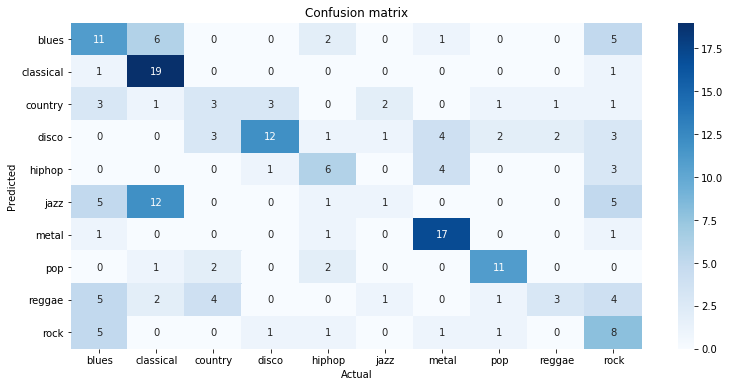

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(test_set['genre/label'].to_list(), predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=df_genre['genre'].values,
            yticklabels=df_genre['genre'].values,
            cmap="Blues")
            
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [63]:
d = {
    'Model': 'Naive-Bayes',
    'Test Set Accuracy': result*100
}

df_models_nb = pd.DataFrame(d, index=[0])

In [64]:
with open('models/nb.pickle', 'wb') as output:
    pickle.dump(classifier, output)

with open('models/df_models_nb.pickle', 'wb') as output:
    pickle.dump(df_models_nb, output)